In [1]:
# Imports
import numpy as np
import scipy as sp
import pandas as pd
import random

import sys
sys.path.append("../code/scripts/")
import chargepatterns as cp

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import IUPAC

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

## Set seed for consistency
### In the future when writing code with random remember to use new methods which explicitly create generators
seed = 212121

In [2]:
# Import proteome data
scerprot = []
#for record in SeqIO.parse("../data/orf_trans_all_R64-2-1_20150113.fasta", "fasta"):
for record in SeqIO.parse("../data/ref_proteomes/Saccharomyces_cerevisiae.fasta", "fasta"):
    scerprot.append(record)

### Data

#### Window size 50

In [3]:
scer_fclist50 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 50
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist50.append(fraccharge)
        i += 5

In [4]:
fc50_mean = np.mean(scer_fclist50)
fc50_sigma = np.std(scer_fclist50)

fc50_2sigma = fc50_mean + 2*fc50_sigma
fc50_2sigma

0.42130804856614906

In [5]:
df = pd.read_csv('../data/charged_regions/cr_trimmed_raw.csv',
                comment="#")

In [6]:
(np.min(df['frac.charge']) - fc50_mean) / fc50_sigma

2.079771865494243

#### Window size 100

In [7]:
scer_fclist100 = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    windowsize = 100
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scer_fclist100.append(fraccharge)
        i += 5

In [8]:
fc100_mean = np.mean(scer_fclist100)
fc100_sigma = np.std(scer_fclist100)

fc100_2sigma = fc100_mean + 2*fc100_sigma
fc100_2sigma

0.39078439419686906

#### Randomized

In [9]:
import string

def get_aa_freqs(seq, counts = False, sort_output = True, gaps = False):
    """
    Arguments:
    seq: a sequences (string representing a protein, drawn from the 20 naturally-occuring amino acids)
    counts: bool, whether to return the counts in each category or the frequencies. False (returns freqs) by default.
    sort_output: bool, whether to return the frequencies or counts in alphabetically sorted order. True by default.
    If false, the categories will also be returned.
    Returns:
    aas: if unsorted, an iterable of the categories (amino acids) represented for each sequence
    freqs: an interable of the frequency of each category in the sequence.
        The indices match the categories in the same index in 'aas'.
        If counts is True, this will be raw counts rather than frequency.
        If sort_output is True only the frequencies will be returned, the assumed order is the
        amino acids in alphabetical order.
    """
    # Amino acids
    forbidden = ['B', 'J', 'O', 'U', 'X', 'Z']
    aas = []
    for a in string.ascii_uppercase:
        if a not in forbidden:
            aas.append(a)
    if gaps:
        aas.append('-')
    
    all_seq_aas = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_aas, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_aas = np.setxor1d(aas, seq_aas)

    seq_aas = np.append(seq_aas, zero_freq_aas)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_aas.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_aas.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_aas.append(seq_aas)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_aas, all_seq_freqs)

In [10]:
# Average aa composition of yeast proteome
scercomp = np.zeros(20)
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    scercomp = np.add(scercomp, get_aa_freqs(seq))
scercomp = np.divide(scercomp, len(scerprot))[0]

In [11]:
# Amino acids
forbidden = ['B', 'J', 'O', 'U', 'X', 'Z']
aas = []
for a in string.ascii_uppercase:
    if a not in forbidden:
        aas.append(a)    

np.random.seed(seed)        
        
scernull = []
for orf in scerprot:
    seq = str(orf.seq).replace('*', '')
    seqlen = len(seq)
    nullseq = "".join(np.random.choice(aas, size=seqlen, p=scercomp))
    scernull.append(nullseq)

In [12]:
scernull_fclist = []
for seq in scernull:
    windowsize = 50
    i = 0
    while (i + windowsize < (len(seq)+5)):
        blob = seq[i: i+windowsize]
        fraccharge = cp.fraction_charged(blob)
        scernull_fclist.append(fraccharge)
        i += 5

In [13]:
fcnull50_mean = np.mean(scernull_fclist)
fcnull50_sigma = np.std(scernull_fclist)

fcnull50_2sigma = fcnull50_mean + 2*fcnull50_sigma
fcnull50_2sigma

0.3515990563845538

## S1A

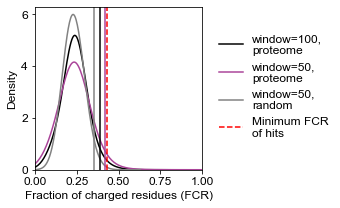

In [19]:
fig, ax = plt.subplots(figsize=(3,3))

sns.kdeplot(scer_fclist100, bw_method=0.5, color = 'black', label = "window=100,\nproteome")
sns.kdeplot(scer_fclist50, bw_method=0.5, color = cscheme["cr"], label = "window=50,\nproteome")
sns.kdeplot(scernull_fclist, bw_method=0.5, color=cscheme["dis"], label = "window=50,\nrandom")

ax.axvline(x=fc100_2sigma, ymin=0, ymax=100000, color = "black")
ax.axvline(x=fc50_2sigma, ymin=0, ymax=100000, color=cscheme["cr"])
ax.axvline(x=fcnull50_2sigma, ymin=0, ymax=100000, color = cscheme["dis"])
ax.axvline(x=np.min(df['frac.charge']), ymin=0, ymax=100000, color = "red", ls='--', label="Minimum FCR\nof hits")

ax.set_xlabel('Fraction of charged residues (FCR)')
ax.set_xlim((0,1))
ax.set_ylabel('Density')
plt.legend(bbox_to_anchor=(1.82, 0.9), frameon=False)

#plt.tight_layout()
plt.savefig('./plots/FigureS1A.png', dpi=300, bbox_inches='tight')
plt.show()

## S1B

In [24]:
charged_hits = pd.read_table("../data/charged_regions/cr_raw.csv",
                           sep = ',', skiprows = 0, comment='#')

In [21]:
entire_protein_fcrs = []
for orf in scerprot:
    seq = str(orf.seq).replace("*", "")
    entire_protein_fcrs.append(cp.fraction_charged(seq))
proteome_mean_fcr = np.mean(entire_protein_fcrs)
proteome_2sigma = proteome_mean_fcr + 2*np.std(entire_protein_fcrs)

In [22]:
hits_orfs = pd.unique(charged_hits["orf"])

In [23]:
hits_fcrs = []
hits_no_region_fcrs = []
per_of_protein = []

for orf in scerprot:
    if orf.name in hits_orfs:
        seq = str(orf.seq).replace("*", "")
        hits_fcrs.append(cp.fraction_charged(seq))
        regions = charged_hits.set_index("orf").loc[orf.name]["region.seq"]
        if (type(regions) == str):
            no_region = seq.replace(regions, "")
            if len(no_region) > 0:
                hits_no_region_fcrs.append(cp.fraction_charged(no_region))
        else:
            no_region = seq
            for i in regions:
                no_region = no_region.replace(i, "")
            if len(no_region) > 0:
                hits_no_region_fcrs.append(cp.fraction_charged(no_region))
        
        if len(no_region) > 0:
            per_of_protein.append(len(no_region) / len(seq))
        
hits_mean_fcr = np.mean(hits_fcrs)
no_region_mean_fcr = np.mean(hits_no_region_fcrs)

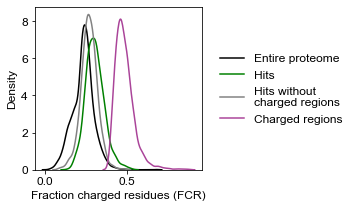

In [30]:
fig, ax = plt.subplots(figsize=(3,3))
sns.kdeplot(entire_protein_fcrs, color = 'black', label="Entire proteome")
sns.kdeplot(hits_fcrs, color = "green", label = "Hits")
sns.kdeplot(hits_no_region_fcrs, color = cscheme["dis"], label = "Hits without\ncharged regions")
sns.kdeplot(charged_hits["frac.charge"], color = cscheme["cr"], label = "Charged regions")

plt.xlabel('Fraction charged residues (FCR)')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.9, 0.78), frameon=False)
plt.savefig('./plots/FigureS1B.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure S2

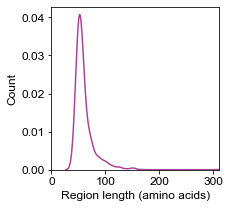

In [34]:
plt.figure(figsize=(3,3))
sns.kdeplot(charged_hits["region.len"], color=cscheme["cr"])
plt.xlim((0,310))
plt.xlabel("Region length (amino acids)")
plt.ylabel("Count")
plt.savefig('./plots/FigureS1C.png', dpi=300, bbox_inches='tight')
plt.show()